For this exercise you should go back to basics and assume simple random channel allocation. Consider a scenario with $M = 64$ and $K = 13$. As for the number of channel pay attention to the following important consideration: you will repeat simulations for values of $N$ starting at $N = 1$ up to $N = 10$. Write down the KPIs for each value of $N$ and organize the results in terms of graphics. In particular, plot KPIs
against the variation of $N$.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(12)

In [2]:
# Função que transforma Linear para dB
def lin2db(x):
    return 10 * np.log10(x)

# Função que transforma dB para Linear
def db2lin(x):
    return 10 ** (x / 10)

# Função que transforma Linear para dBm
def lin2dbm(x):
    return 10 * np.log10(x) + 30

# Função que transforma dBm para Linear
def dbm2lin(x):
    return 10 ** ((x - 30) / 10)

In [3]:
# Função que define os eixos x e y da CDF
def cdf(dados):
    '''Função que calcula a Cumulative Distribution Function (CDF) de um conjunto de dados.
    Parâmetros:
    dados: array. Conjunto de dados.
    Retorno:
    x: array. Dados ordenados.
    y: array. Probabilidade acumulada de cada dado.'''

    x = np.sort(dados)
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

In [4]:
# Função que gera as coordenadas dos APs
def distribuir_APs(num_aps, area):
    '''Distributes Access Points (APs) evenly within a square area.
    
    Parameters:
    num_aps (int): The number of APs to distribute. Must be a perfect square.
    area (int): The length of the side of the square area in which to distribute the APs.
    
    Returns:
    np.array: An array of coordinates for the APs, or None if num_aps is not a perfect square.'''
    
    if num_aps not in [1, 4, 9, 16, 25, 36, 49, 64, 100]:
        return None

    tamanho_quadrado = area
    lado_quadrado = int(np.sqrt(num_aps))

    tamanho_celula = tamanho_quadrado // lado_quadrado

    # Criar coordenadas usando meshgrid
    x, y = np.meshgrid(np.arange(0.5 * tamanho_celula, tamanho_quadrado, tamanho_celula),
                      np.arange(0.5 * tamanho_celula, tamanho_quadrado, tamanho_celula))

    coordenadas_APs = np.column_stack((x.ravel(), y.ravel()))

    return coordenadas_APs

In [5]:
# Função que gera a distância entre a UE e a AP
def dAPUE(x_coord, y_coord, ap_coord, d_reference=1):
  '''Calculate the Euclidean distance between a user equipment (UE) and an access point (AP).
    
    Parameters:
    ue_coords (tuple): A tuple (x_coord, y_coord) representing the coordinates of the UE.
    ap_coords (np.array): An array containing the coordinates of the APs.
    
    Returns:
    float: The Euclidean distance between the UE and the AP. If the euclidean distance is less than 1, return 1.
  '''
  dAPUE = np.linalg.norm(np.array([x_coord, y_coord]) - ap_coord)
  if dAPUE < d_reference:
    return d_reference
  else:
    return dAPUE

In [6]:
#Função que define o shadowing para cada usuário
def find_shadowing(standard_shadow, ues, aps):
    '''Generate a shadowing value for a user.

    Parameters:
    standard_shadow (float): The standard deviation of the shadowing values.
    ues (int): The number of user equipment (UE) in the simulation.
    aps (int): The number of access points (APs) in the

    Returns:
    np.array: A 2D array of shadowing values for each UE and AP.
    '''

    shadowing = np.random.lognormal(0, standard_shadow, (ues, aps))

    return shadowing 

In [7]:
def find_fastfading(standard_fading, ues, aps, channels):
    '''Função que calcula o fast fading para um dado usuário.
    
    Parâmetros:
    standard_fading (float): O desvio padrão da distribuição normal.
    ues (int): O número de usuários.
    aps (int): O número de pontos de acesso.
    channels (int): O número de canais.
    
    Retorna:
    np.array: Um array 3D com os valores de fast fading para cada usuário, ponto de acesso e canal.
    '''

    fast_fading = np.sqrt( (standard_fading * np.random.randn(ues, aps, channels))**2 + (standard_fading * np.random.randn(ues, aps, channels))**2 )

    return fast_fading

In [8]:
def find_pathgain(dist, shadowing, fastfading):
    ambiente_const = 1e-4
    pathloss_const = 4

    # Número de canais
    num_channels = fastfading.shape[2]

    # Expandindo o shadowing e o dist para ter a mesma forma que o fastfading
    shadowing_expanded = np.repeat(shadowing[:, :, np.newaxis], num_channels, axis=2)  # Agora tem forma (ues, aps, num_channels)
    dist_expanded = np.repeat((dist ** pathloss_const)[:, :, np.newaxis], num_channels, axis=2)  # Agora tem forma (ues, aps, num_channels)

    # Calculando o path gain
    path_gain_result = (shadowing_expanded * (ambiente_const / dist_expanded)) * (fastfading ** 2)

    return path_gain_result


In [9]:
def ue_channel_random(shadowing, fastfading, distance_APUE):
    '''
    Lembrando que [ue, aps, channels] é a dimensão do path_gain.
    Função que seleciona aleatoriamente um canal para cada usuário.
    
    Parâmetros:
    distance_APUE (np.array): Um array 2D com as distâncias entre cada usuário e ponto de acesso.
    shadowing (np.array): Um array 2D com os valores de shadowing para cada usuário e ponto de acesso.
    fastfading (np.array): Um array 3D com os valores de fast fading para cada usuário, ponto de acesso e canal.
    
    Retorna:
    np.array: Um array 3D com os valores de path gain de cada usuário, onde apenas um canal aleatório é mantido para cada usuário.
    '''

    path_gain = find_pathgain(distance_APUE, shadowing, fastfading)

    # Garantindo que temos mais de um canal:
    if path_gain.shape[2] > 1:
        for ue in range(path_gain.shape[0]):
            channel = np.random.randint(0, path_gain.shape[2])  # Seleciona um canal aleatório para o UE

            for ap in range(path_gain.shape[1]):
                for ch in range(path_gain.shape[2]):
                    if ch != channel:
                        path_gain[ue, ap, ch] = 0

    return path_gain


In [10]:
def ue_channel_maxpath(shadowing, fastfading, distance_APUE):
    '''
    Lembrando que [ue, aps, channels] é a dimensão do path_gain.
    Função que calcula o canal com maior path gain para cada usuário.
    
    Parâmetros:
    distance_APUE (np.array): Um array 2D com as distâncias entre cada usuário e ponto de acesso.
    shadowing (np.array): Um array 2D com os valores de shadowing para cada usuário e ponto de acesso.
    fastfading (np.array): Um array 3D com os valores de fast fading para cada usuário, ponto de acesso e canal.
    
    Retorna:
    np.array: Um array 3D com os valores de path gain para cada usuário, ponto de acesso e canal, sendo que apenas o canal com maior path gain é mantido.
    '''

    path_gain = find_pathgain(distance_APUE, shadowing, fastfading)

    for ue in range(path_gain.shape[0]):
        # Achando o canal com maior path_gain para cada AP do UE atual
        index_max = np.argmax(path_gain[ue, :, :], axis=1)

        # Mantendo apenas o canal com maior path_gain
        for ap in range(path_gain.shape[1]):
            for channel in range(path_gain.shape[2]):
                if channel != index_max[ap]:
                    path_gain[ue, ap, channel] = 0

    return path_gain


In [11]:
def ue_channel_maxpath_realoc(shadowing, fastfading, distance_APUE):
    '''
    Lembrando que [ue, aps, channels] é a dimensão do path_gain.
    Função que calcula o canal com maior path gain para cada usuário e realoca o usuário caso tenha mais de um usuário alocado na mesma AP e no mesmo canal.
    
    Parâmetros:
    distance_APUE (np.array): Um array 2D com as distâncias entre cada usuário e ponto de acesso.
    shadowing (np.array): Um array 2D com os valores de shadowing para cada usuário e ponto de acesso.
    fastfading (np.array): Um array 3D com os valores de fast fading para cada usuário, ponto de acesso e canal.
    
    Retorna:
    np.array: Um array 3D com os valores de path gain para cada usuário, ponto de acesso e canal, sendo que apenas o canal com maior path gain é mantido, e caso tenha mais de um usuário alocado na mesma AP e no mesmo canal, o usuário com menor path gain é realocado para o canal com menor path gain.
    '''
    # Fazemos primeiramente a alocação de canais inicial 
    path_gain = find_pathgain(distance_APUE, shadowing, fastfading)
    for ue in range(path_gain.shape[0]):
        # Achando o canal com maior path_gain para cada AP do UE atual
        index_max = np.argmax(path_gain[ue, :, :], axis=1)

        # Mantendo apenas o canal com maior path_gain
        for ap in range(path_gain.shape[1]):
            for channel in range(path_gain.shape[2]):
                if channel != index_max[ap]:
                    path_gain[ue, ap, channel] = 0
    
    # Verificar se há mais de um usuário alocado na mesma AP e no mesmo canal
    for ap in range(path_gain.shape[1]):
        for channel in range(path_gain.shape[2]):

            ues_same_channel = np.where(path_gain[:, ap, channel] != 0)[0] # Pega os usuários que estão no mesmo canal

            if len(ues_same_channel) > 1:
                # Realocação se houver mais de um usuário no mesmo AP e canal
                for ue_conflict in ues_same_channel:
                    vacant_channel = np.where(path_gain[ue_conflict, ap, :] == 0)[0] # Pega os canais vazios para o AP

                    if len(vacant_channel) > 0: # Se tiver algum canal vazio
                        path_min = np.argmin(path_gain[ue_conflict, ap, vacant_channel]) # Pega o canal com menor path gain
                        selected_channel = vacant_channel[path_min]

                        # Realoca o usuário para o canal com menor path gain
                        path_gain[ue_conflict, ap, selected_channel] = path_gain[ue_conflict, ap, channel]

                        # Zera o canal antigo
                        path_gain[ue_conflict, ap, channel] = 0

    return path_gain


In [12]:
def ue_channel_partialortho(shadowing, fastfading, distance_APUE):
    '''
    Lembrando que [ue, aps, channels] é a dimensão do path_gain.
    Função que faz a alocação de recurso usando o algoritmo de partial orthogonalization, impedindo de ter mais de um usuário no mesmo Canal-AP que o outro usuário.
    
    Parâmetros:
    distance_APUE (np.array): Um array 2D com as distâncias entre cada usuário e ponto de acesso.
    shadowing (np.array): Um array 2D com os valores de shadowing para cada usuário e ponto de acesso.
    fastfading (np.array): Um array 3D com os valores de fast fading para cada usuário, ponto de acesso e canal.
    
    Retorna:
    np.array: Um array 3D com os valores de path gain de cada usuário, onde o algoritmo impede que tenha mais de um usuário no mesmo Canal-AP.
    '''

    path_gain = find_pathgain(distance_APUE, shadowing, fastfading)

    path_gain_ortho = np.zeros_like(path_gain)
    # Fazendo uma máscara booleana para definir quais combinações eu posso utilizar
    disp = np.ones((path_gain.shape[1], path_gain.shape[2]), dtype=bool)

    # Alocando agora cada UE para o melhor canal possível disponível
    for ue in range(path_gain.shape[0]):
        higher_gain = -np.inf  # Garantindo que qualquer ganho será maior que -inf
        best_comb = None

        for ap in range(path_gain.shape[1]):
            for channel in range(path_gain.shape[2]):
                if disp[ap, channel]:  # Se a combinação está disponível
                    if path_gain[ue, ap, channel] > higher_gain:
                        higher_gain = path_gain[ue, ap, channel]
                        best_comb = (ap, channel)

        # Alocando o usuário para o melhor canal possível
        if best_comb:
            selected_ap, selected_channel = best_comb
            path_gain_ortho[ue, selected_ap, selected_channel] = path_gain[ue, selected_ap, selected_channel]

            # Bloqueando as combinações que não podem ser utilizadas
            disp[selected_ap, selected_channel] = False

    return path_gain_ortho


In [13]:
def calculate_sinr(banda, K_0, aps, ues, channels, sigma_shadowing, sigma_fastfading, p_t, rrm_index, area):
    '''Função que calcula a SINR para múltiplos UEs e APs em diferentes canais.

    i-th UE, j-th AP, c-th channel
    
    Lembrando que [ue, aps, channels] é a dimensão da matriz path_gain. 

    Parâmetros:
    banda (float): Largura de banda total.
    K_0 (float): Constante de ruído.
    aps (int): Número de APs.
    ues (int): Número de UEs.
    channels (int): Número de canais.
    sigma_shadowing (float): Desvio padrão para o shadowing.
    sigma_fastfading (float): Desvio padrão para o fast fading.
    p_t (float): Potência de transmissão.
    rrm_index (int): Índice para o tipo de algoritmo de alocação de recursos.
    area (float): Área de distribuição dos APs.
    
    Retorna:
    np.array: O valor do SINR para cada UE.
    '''
    # Inicializações
    x_coord, y_coord, aps_position = np.zeros(ues), np.zeros(ues), distribuir_APs(aps, area)
    dist = np.zeros((ues, aps))
    shadowing = find_shadowing(sigma_shadowing, ues, aps)
    fastfading = find_fastfading(sigma_fastfading, ues, aps, channels)
    power_trans = np.ones(ues) * p_t
    power_noise = np.ones(ues) * (K_0 * banda / channels)

    # Coordenadas dos UEs
    for ue_index in range(ues):
        x_coord[ue_index] = np.random.randint(0, area)
        y_coord[ue_index] = np.random.randint(0, area)

    # Distância entre UEs e APs
    for ue_index in range(ues):
        for ap_index in range(aps):
            dist[ue_index][ap_index] = dAPUE(x_coord[ue_index], y_coord[ue_index], aps_position[ap_index])

    # Cálculo do path gain
    if rrm_index == 0:
        path_gain = ue_channel_maxpath(shadowing, fastfading, dist)
    elif rrm_index == 1:
        path_gain = ue_channel_maxpath_realoc(shadowing, fastfading, dist)
    elif rrm_index == 2:
        path_gain = ue_channel_partialortho(shadowing, fastfading, dist)
    elif rrm_index == 3:
        path_gain = ue_channel_random(shadowing, fastfading, dist)

    # Cálculo do SINR
    sinr_total = np.zeros(path_gain.shape)
    sinr_ue = np.zeros(path_gain.shape[0])

    for ue_index in range(path_gain.shape[0]):
        for ap_index in range(path_gain.shape[1]):
            for channel_index in range(path_gain.shape[2]):
                # Calculando a potência recebida para o canal atual
                power_received = np.abs(path_gain[ue_index, ap_index, channel_index]) * power_trans[ue_index]
    
                # Calculando a interferência no mesmo canal
                interference_sum = 0
                for other_ue_index in range(path_gain.shape[0]):
                    if other_ue_index != ue_index:  # Se não for o mesmo usuário
                        interference_sum += np.abs(path_gain[other_ue_index, ap_index, channel_index]) * power_trans[other_ue_index]

                # Cálculo da SINR para o canal, UE e AP atuais
                sinr_total[ue_index, ap_index, channel_index] = power_received / (interference_sum + power_noise[ue_index])

    # Selecionar o maior valor de SINR para cada UE
    for ue_index in range(sinr_total.shape[0]):
        sinr_ue[ue_index] = np.max(sinr_total[ue_index, :, :])

    return sinr_ue


In [14]:
def find_capacity(sinr, banda, channels):
    '''Função que calcula a capacidade de um dado canal.
    
    Parâmetros:
    sinr (list): A relação sinal ruído mais interferência.
    banda (int): A largura de banda do canal.    
    channels (int): O número de canais.
    Retorna:
    list: A capacidade do canal.'''

    banda_channel = banda / channels
    
    capacity = banda_channel * np.log2(1 + sinr)
    
    return capacity

In [15]:
bandwidth , transmit_power, d_min, K_0 = 100e6, 1, 1, 1e-20 # Em MHz, mW, metros, mW/Hz respectivamente
aps, ues = 64, 13
channel1, channel2, channel3, channel4, channel5, channel6, channel7, channel8, channel9, channel10 = 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
area = 1000
sigma_shadowing = 2
sigma_fastfading = 1/np.sqrt(2)
maxpath, maxpath_plus_realoc, partial_ortho, random = 0, 1, 2, 3 # Maxpath, Maxpath + Realoc, Partial orthogonalization, Random
iterat = 1000

In [16]:
# Demora 40 minutos para rodar, vai mesmo fazer isso?

capacity_acum_1 = np.array([])
capacity_acum_2 = np.array([])
capacity_acum_3 = np.array([])
capacity_acum_4 = np.array([])
capacity_acum_5 = np.array([])
capacity_acum_6 = np.array([])
capacity_acum_7 = np.array([])
capacity_acum_8 = np.array([])
capacity_acum_9 = np.array([])
capacity_acum_10 = np.array([])


sinr_acum_1 = np.array([])
sinr_acum_2 = np.array([])
sinr_acum_3 = np.array([])
sinr_acum_4 = np.array([]) 
sinr_acum_5 = np.array([])
sinr_acum_6 = np.array([])
sinr_acum_7 = np.array([])
sinr_acum_8 = np.array([])
sinr_acum_9 = np.array([])
sinr_acum_10 = np.array([])

for iterations in range (1000):
    sinr_1 = calculate_sinr(bandwidth, K_0, aps, ues, channel1, sigma_shadowing, sigma_fastfading, transmit_power, random, area)
    sinr_2 = calculate_sinr(bandwidth, K_0, aps, ues, channel2, sigma_shadowing, sigma_fastfading, transmit_power, random, area)
    sinr_3 = calculate_sinr(bandwidth, K_0, aps, ues, channel3, sigma_shadowing, sigma_fastfading, transmit_power, random, area)
    sinr_4 = calculate_sinr(bandwidth, K_0, aps, ues, channel4, sigma_shadowing, sigma_fastfading, transmit_power, random, area)
    sinr_5 = calculate_sinr(bandwidth, K_0, aps, ues, channel5, sigma_shadowing, sigma_fastfading, transmit_power, random, area)
    sinr_6 = calculate_sinr(bandwidth, K_0, aps, ues, channel6, sigma_shadowing, sigma_fastfading, transmit_power, random, area)
    sinr_7 = calculate_sinr(bandwidth, K_0, aps, ues, channel7, sigma_shadowing, sigma_fastfading, transmit_power, random, area)
    sinr_8 = calculate_sinr(bandwidth, K_0, aps, ues, channel8, sigma_shadowing, sigma_fastfading, transmit_power, random, area)
    sinr_9 = calculate_sinr(bandwidth, K_0, aps, ues, channel9, sigma_shadowing, sigma_fastfading, transmit_power, random, area)
    sinr_10 = calculate_sinr(bandwidth, K_0, aps, ues, channel10, sigma_shadowing, sigma_fastfading, transmit_power, random, area)


    capacity_1 = find_capacity(sinr_1, bandwidth, channel1)
    capacity_2 = find_capacity(sinr_2, bandwidth, channel2)
    capacity_3 = find_capacity(sinr_3, bandwidth, channel3)
    capacity_4 = find_capacity(sinr_4, bandwidth, channel4)
    capacity_5 = find_capacity(sinr_5, bandwidth, channel5)
    capacity_6 = find_capacity(sinr_6, bandwidth, channel6)
    capacity_7 = find_capacity(sinr_7, bandwidth, channel7)
    capacity_8 = find_capacity(sinr_8, bandwidth, channel8)
    capacity_9 = find_capacity(sinr_9, bandwidth, channel9)
    capacity_10 = find_capacity(sinr_10, bandwidth, channel10)

    sinr_acum_1 = np.append(sinr_acum_1, sinr_1)
    sinr_acum_2 = np.append(sinr_acum_2, sinr_2)
    sinr_acum_3 = np.append(sinr_acum_3, sinr_3)
    sinr_acum_4 = np.append(sinr_acum_4, sinr_4)
    sinr_acum_5 = np.append(sinr_acum_5, sinr_5)
    sinr_acum_6 = np.append(sinr_acum_6, sinr_6)
    sinr_acum_7 = np.append(sinr_acum_7, sinr_7)
    sinr_acum_8 = np.append(sinr_acum_8, sinr_8)
    sinr_acum_9 = np.append(sinr_acum_9, sinr_9)
    sinr_acum_10 = np.append(sinr_acum_10, sinr_10)

    capacity_acum_1 = np.append(capacity_acum_1, capacity_1)
    capacity_acum_2 = np.append(capacity_acum_2, capacity_2)
    capacity_acum_3 = np.append(capacity_acum_3, capacity_3)
    capacity_acum_4 = np.append(capacity_acum_4, capacity_4)
    capacity_acum_5 = np.append(capacity_acum_5, capacity_5)
    capacity_acum_6 = np.append(capacity_acum_6, capacity_6)
    capacity_acum_7 = np.append(capacity_acum_7, capacity_7)
    capacity_acum_8 = np.append(capacity_acum_8, capacity_8)
    capacity_acum_9 = np.append(capacity_acum_9, capacity_9)
    capacity_acum_10 = np.append(capacity_acum_10, capacity_10)



In [17]:
# Deixando em crescente
sinr_acum_1 = np.sort(lin2db(sinr_acum_1))
sinr_acum_2 = np.sort(lin2db(sinr_acum_2))
sinr_acum_3 = np.sort(lin2db(sinr_acum_3))
sinr_acum_4 = np.sort(lin2db(sinr_acum_4))
sinr_acum_5 = np.sort(lin2db(sinr_acum_5))
sinr_acum_6 = np.sort(lin2db(sinr_acum_6))
sinr_acum_7 = np.sort(lin2db(sinr_acum_7))
sinr_acum_8 = np.sort(lin2db(sinr_acum_8))
sinr_acum_9 = np.sort(lin2db(sinr_acum_9))
sinr_acum_10 = np.sort(lin2db(sinr_acum_10))

capacity_acum_1 = np.sort(capacity_acum_1)
capacity_acum_2 = np.sort(capacity_acum_2)
capacity_acum_3 = np.sort(capacity_acum_3)
capacity_acum_4 = np.sort(capacity_acum_4)
capacity_acum_5 = np.sort(capacity_acum_5)
capacity_acum_6 = np.sort(capacity_acum_6)
capacity_acum_7 = np.sort(capacity_acum_7)
capacity_acum_8 = np.sort(capacity_acum_8)
capacity_acum_9 = np.sort(capacity_acum_9)
capacity_acum_10 = np.sort(capacity_acum_10)


In [18]:
# Pegando o 50% da capacidade 
cap_random_1_50 = np.percentile(capacity_acum_1, 50)
cap_random_2_50 = np.percentile(capacity_acum_2, 50)
cap_random_3_50 = np.percentile(capacity_acum_3, 50)
cap_random_4_50 = np.percentile(capacity_acum_4, 50)
cap_random_5_50 = np.percentile(capacity_acum_5, 50)
cap_random_6_50 = np.percentile(capacity_acum_6, 50)
cap_random_7_50 = np.percentile(capacity_acum_7, 50)
cap_random_8_50 = np.percentile(capacity_acum_8, 50)
cap_random_9_50 = np.percentile(capacity_acum_9, 50)
cap_random_10_50 = np.percentile(capacity_acum_10, 50)

# Pegando o 50% da SINR
sinr_random_1_db_50 = np.percentile(sinr_acum_1, 50)
sinr_random_2_db_50 = np.percentile(sinr_acum_2, 50)
sinr_random_3_db_50 = np.percentile(sinr_acum_3, 50)
sinr_random_4_db_50 = np.percentile(sinr_acum_4, 50)
sinr_random_5_db_50 = np.percentile(sinr_acum_5, 50)
sinr_random_6_db_50 = np.percentile(sinr_acum_6, 50)
sinr_random_7_db_50 = np.percentile(sinr_acum_7, 50)
sinr_random_8_db_50 = np.percentile(sinr_acum_8, 50)
sinr_random_9_db_50 = np.percentile(sinr_acum_9, 50)
sinr_random_10_db_50 = np.percentile(sinr_acum_10, 50)



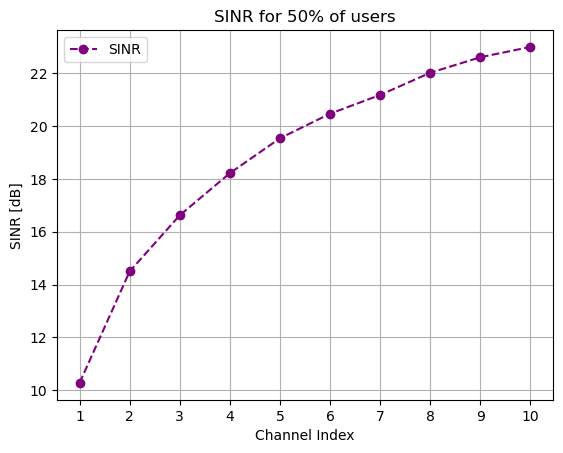

In [19]:
x_axis = np.arange(1, 11)
y_axis = np.arange(10,24)
plt.figure()
plt.plot(x_axis, [sinr_random_1_db_50, sinr_random_2_db_50, sinr_random_3_db_50, sinr_random_4_db_50, sinr_random_5_db_50, sinr_random_6_db_50, sinr_random_7_db_50, sinr_random_8_db_50, sinr_random_9_db_50, sinr_random_10_db_50], marker='o', label='SINR', linestyle = '--', color = 'purple')
plt.xlabel('Channel Index')
plt.ylabel('SINR [dB]')
plt.title('SINR for 50% of users')
plt.grid()
plt.xticks(x_axis)
plt.legend()
plt.savefig('Q4_SINR_50.pdf')
plt.show()



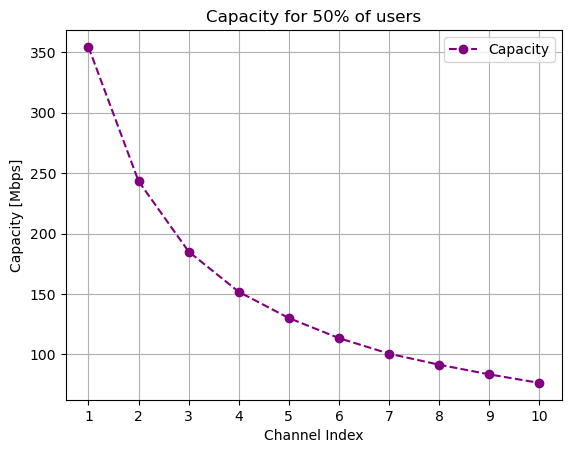

In [20]:
plt.figure()

# Plotando os dados com marcadores
plt.plot(x_axis, [cap_random_1_50/1e6, cap_random_2_50/1e6, cap_random_3_50/1e6, cap_random_4_50/1e6, cap_random_5_50/1e6, cap_random_6_50/1e6, cap_random_7_50/1e6, cap_random_8_50/1e6, cap_random_9_50/1e6, cap_random_10_50/1e6], marker='o', label='Capacity', linestyle = '--', color = 'purple')

plt.xlabel('Channel Index')
plt.ylabel('Capacity [Mbps]')
plt.title('Capacity for 50% of users')
plt.xticks(x_axis)
plt.grid()
plt.legend()
plt.savefig('Q4_Cap_50.pdf')
plt.show()

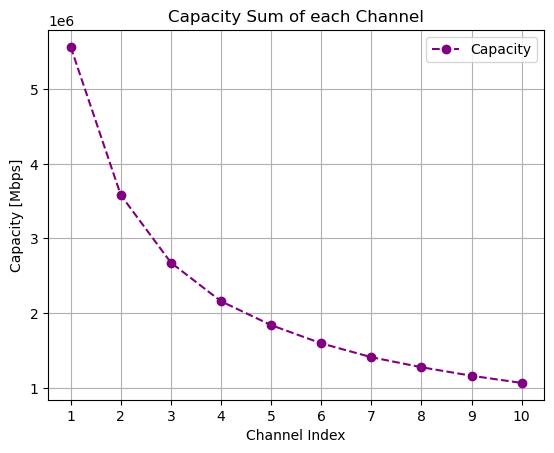

In [21]:
# Plotando a soma da capacidade
plt.figure()
plt.plot(x_axis, [np.sum(capacity_acum_1)/1e6, np.sum(capacity_acum_2)/1e6, np.sum(capacity_acum_3)/1e6, np.sum(capacity_acum_4)/1e6, np.sum(capacity_acum_5)/1e6, np.sum(capacity_acum_6)/1e6, np.sum(capacity_acum_7)/1e6, np.sum(capacity_acum_8)/1e6, np.sum(capacity_acum_9)/1e6, np.sum(capacity_acum_10)/1e6], marker='o', label='Capacity', linestyle='--', color='purple')

plt.xlabel('Channel Index')
plt.ylabel('Capacity [Mbps]')
plt.title('Capacity Sum of each Channel')
plt.xticks(x_axis)
plt.grid()
plt.legend()
plt.savefig('Q4_Cap_Sum.pdf')
plt.show()


Question 5

Based on the results from the previous exercise plot a graphic that shows
the ratio between the 50-th and 10-th percentiles of the per-UE channel capacity as a
function of N. Let us call this ratio the fairness index. The higher the fairness index,
the more unfair is the system as a whole (i.e. the performance disparity between mid-cell
and cell-border is greater). In a system in which cell-center and cell-border UEs have
the same channel capacity the fairness index would be equal to 1. What do you observe
by plotting the fairness index?

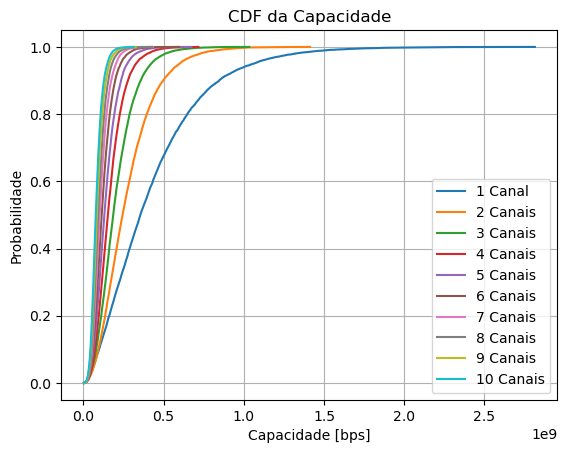

In [22]:
# Plotando a CDF da Capacidade
plt.figure()
plt.plot(np.sort(capacity_acum_1), np.linspace(0, 1, len(capacity_acum_1), endpoint=False), label='1 Canal')
plt.plot(np.sort(capacity_acum_2), np.linspace(0, 1, len(capacity_acum_2), endpoint=False), label='2 Canais')
plt.plot(np.sort(capacity_acum_3), np.linspace(0, 1, len(capacity_acum_3), endpoint=False), label='3 Canais')
plt.plot(np.sort(capacity_acum_4), np.linspace(0, 1, len(capacity_acum_4), endpoint=False), label='4 Canais')
plt.plot(np.sort(capacity_acum_5), np.linspace(0, 1, len(capacity_acum_5), endpoint=False), label='5 Canais')
plt.plot(np.sort(capacity_acum_6), np.linspace(0, 1, len(capacity_acum_6), endpoint=False), label='6 Canais')
plt.plot(np.sort(capacity_acum_7), np.linspace(0, 1, len(capacity_acum_7), endpoint=False), label='7 Canais')
plt.plot(np.sort(capacity_acum_8), np.linspace(0, 1, len(capacity_acum_8), endpoint=False), label='8 Canais')
plt.plot(np.sort(capacity_acum_9), np.linspace(0, 1, len(capacity_acum_9), endpoint=False), label='9 Canais')
plt.plot(np.sort(capacity_acum_10), np.linspace(0, 1, len(capacity_acum_10), endpoint=False), label='10 Canais')
plt.xlabel('Capacidade [bps]')
plt.ylabel('Probabilidade')
plt.title('CDF da Capacidade')
plt.grid()
plt.legend()
#plt.xlim(0,0.6e9)
plt.show()


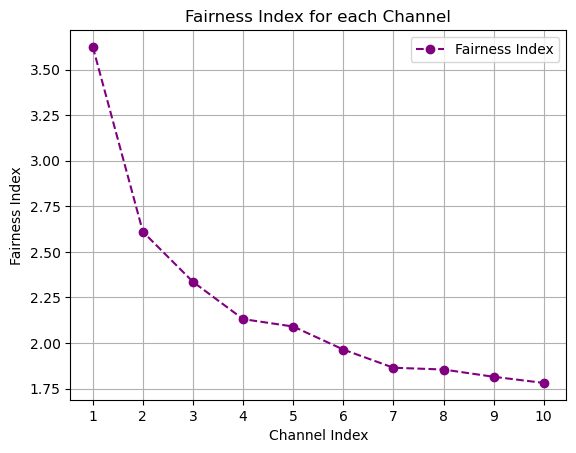

In [23]:
# Calculando o fairneess index da capacidade para cada valor de canal
fainess_index_1 = (cap_random_1_50) / (np.percentile(capacity_acum_1, 10))
fainess_index_2 = (cap_random_2_50) / (np.percentile(capacity_acum_2, 10))
fainess_index_3 = (cap_random_3_50) / (np.percentile(capacity_acum_3, 10))
fainess_index_4 = (cap_random_4_50) / (np.percentile(capacity_acum_4, 10))
fainess_index_5 = (cap_random_5_50) / (np.percentile(capacity_acum_5, 10))
fainess_index_6 = (cap_random_6_50) / (np.percentile(capacity_acum_6, 10))
fainess_index_7 = (cap_random_7_50) / (np.percentile(capacity_acum_7, 10))
fainess_index_8 = (cap_random_8_50) / (np.percentile(capacity_acum_8, 10))
fainess_index_9 = (cap_random_9_50) / (np.percentile(capacity_acum_9, 10))
fainess_index_10 = (cap_random_10_50) / (np.percentile(capacity_acum_10, 10))


                                         
# Plotando o fairneess index
plt.figure()
plt.plot(x_axis, [fainess_index_1, fainess_index_2, fainess_index_3, fainess_index_4, fainess_index_5, fainess_index_6, fainess_index_7, fainess_index_8, fainess_index_9, fainess_index_10], marker='o', label='Fairness Index', linestyle='--', color='purple')

plt.xlabel('Channel Index')
plt.ylabel('Fairness Index')
plt.title('Fairness Index for each Channel')
plt.xticks(x_axis)
plt.grid()
plt.legend()
plt.savefig('Q5_Fairness.pdf')
plt.show()

